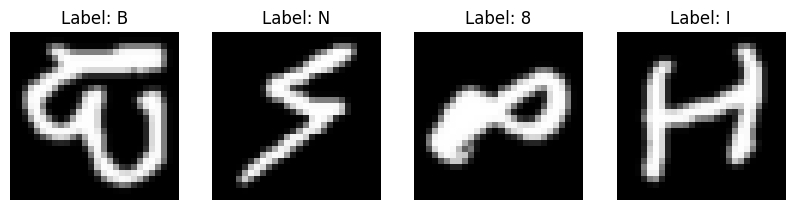

Epoch [1/3], Loss: 1.5380, Accuracy: 0.6656
Epoch [2/3], Loss: 1.1227, Accuracy: 0.6880
Epoch [3/3], Loss: 1.0329, Accuracy: 0.7076


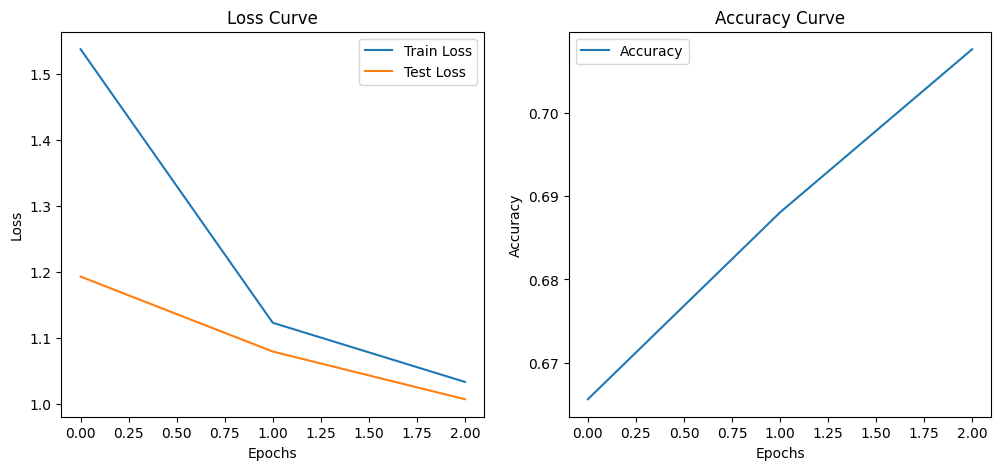

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Download EMNIST dataset
train_dataset = datasets.EMNIST(
    root='/content/sample_data',
    split='byclass',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
)

test_dataset = datasets.EMNIST(
    root='/content/sample_data',
    split='byclass',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Step 2: Visualize few examples of EMNIST (e.g., 'B' vs. '8', 'S' vs. '5')
def visualize_examples():
    labels = [11, 23, 8, 18]  # Indices for 'B', '8', 'S', '5'
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for i, label in enumerate(labels):
        found = False
        for img, target in train_loader:
            if label in target:
                idx = (target == label).nonzero(as_tuple=True)[0]
                axes[i].imshow(img[idx][0].squeeze(), cmap='gray')
                axes[i].set_title(f"Label: {train_dataset.classes[label]}")
                axes[i].axis('off')
                found = True
                break
        if not found:
            print(f"Label {label} not found in the current batch")
    plt.show()

visualize_examples()

# Step 3: Define Bilinear Pooling Network using torch.bmm()
class BilinearCNN(nn.Module):
    def __init__(self, num_classes=62):
        super(BilinearCNN, self).__init__()

        # Define two convolutional streams
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(32 * 32, num_classes)

    def forward(self, x):
        # Apply two convolutional streams
        x1 = self.conv1(x)
        x2 = self.conv2(x)

        # Reshape for bilinear pooling
        x1 = x1.view(x1.size(0), 32, -1)  # (batch_size, num_features, feature_dim)
        x2 = x2.view(x2.size(0), 32, -1)

        # Bilinear pooling using torch.bmm()
        bilinear_output = torch.bmm(x1, x2.transpose(1, 2))  # (batch_size, num_features, num_features)
        bilinear_output = bilinear_output.view(bilinear_output.size(0), -1)  # Flatten

        # Fully connected layer
        output = self.fc(bilinear_output)
        return output

# Initialize the model, loss function, and optimizer
model = BilinearCNN(num_classes=62)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Training and validation
def train_model(num_epochs=3):
    train_losses, test_losses, accuracies = [], [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_losses.append(val_loss / len(test_loader))
        accuracy = correct / total
        accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, test_losses, accuracies

train_losses, test_losses, accuracies = train_model(num_epochs=3)




Adding Batch

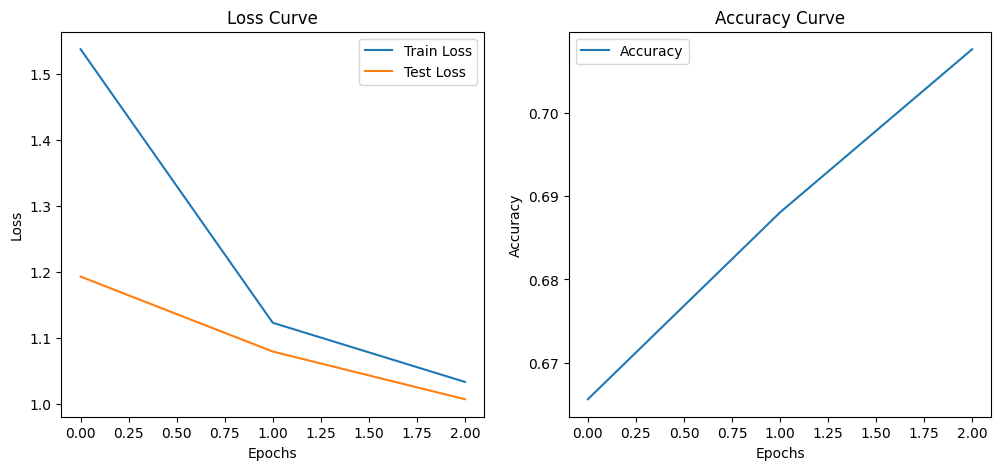

In [6]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies)), accuracies, label='Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

In [8]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 54.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


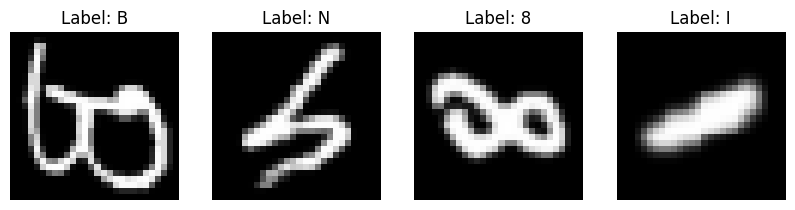

<ipython-input-11-7e32491cadf9>:110: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Use mixed precision to speed up training
<ipython-input-11-7e32491cadf9>:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/3], Loss: 6.1394, Accuracy: 0.5749
Epoch [2/3], Loss: 1.3013, Accuracy: 0.6806
Epoch [3/3], Loss: 1.1005, Accuracy: 0.6882
Training completed in: 9.88 minutes


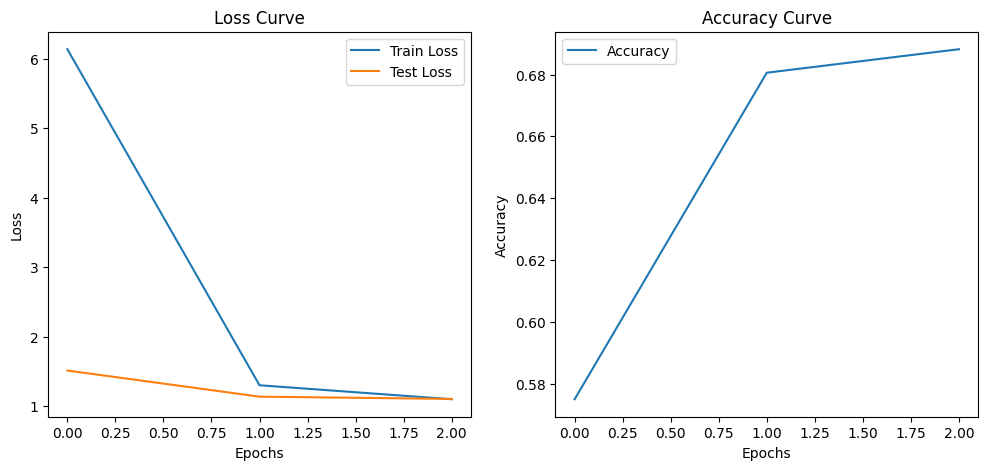

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import time

# Check if CUDA is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Step 1: Download EMNIST dataset
train_dataset = datasets.EMNIST(
    root='/content/sample_data',
    split='byclass',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

test_dataset = datasets.EMNIST(
    root='/content/sample_data',
    split='byclass',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

# Increase batch size to make training faster
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=use_cuda, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=use_cuda, num_workers=4)

# Step 2: Visualize few examples of EMNIST (e.g., 'B' vs. '8', 'S' vs. '5')
def visualize_examples():
    labels = [11, 23, 8, 18]  # Indices for 'B', '8', 'S', '5'
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for i, label in enumerate(labels):
        found = False
        for img, target in train_loader:
            if label in target:
                idx = (target == label).nonzero(as_tuple=True)[0]
                axes[i].imshow(img[idx][0].squeeze(), cmap='gray')
                axes[i].set_title(f"Label: {train_dataset.classes[label]}")
                axes[i].axis('off')
                found = True
                break
        if not found:
            print(f"Label {label} not found in the current batch")
    plt.show()

visualize_examples()

# Step 3: Define Bilinear Pooling Network using torch.bmm() with CuDNN support
class BilinearCNN(nn.Module):
    def __init__(self, num_classes=62):
        super(BilinearCNN, self).__init__()

        # Define two convolutional streams
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1).to(device),
            nn.ReLU().to(device),
            nn.MaxPool2d(2).to(device)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1).to(device),
            nn.ReLU().to(device),
            nn.MaxPool2d(2).to(device)
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(64 * 64, num_classes).to(device)

    def forward(self, x):
        # Apply two convolutional streams
        x1 = self.conv1(x)
        x2 = self.conv2(x)

        # Reshape for bilinear pooling
        x1 = x1.view(x1.size(0), 64, -1)  # (batch_size, num_features, feature_dim)
        x2 = x2.view(x2.size(0), 64, -1)

        # Bilinear pooling using torch.bmm() with custom kernel if possible
        bilinear_output = torch.bmm(x1, x2.transpose(1, 2))  # (batch_size, num_features, num_features)
        bilinear_output = bilinear_output.view(bilinear_output.size(0), -1)  # Flatten

        # Fully connected layer
        output = self.fc(bilinear_output)
        return output

# Initialize the model, loss function, and optimizer
model = BilinearCNN(num_classes=62).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Training and validation

def train_model(num_epochs=3):
    train_losses, test_losses, accuracies = [], [], []
    scaler = torch.cuda.amp.GradScaler()  # Use mixed precision to speed up training
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Mixed precision forward and backward pass
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_losses.append(val_loss / len(test_loader))
        accuracy = correct / total
        accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

    end_time = time.time()
    print(f"Training completed in: {(end_time - start_time) / 60:.2f} minutes")

    return train_losses, test_losses, accuracies

train_losses, test_losses, accuracies = train_model(num_epochs=3)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies)), accuracies, label='Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()




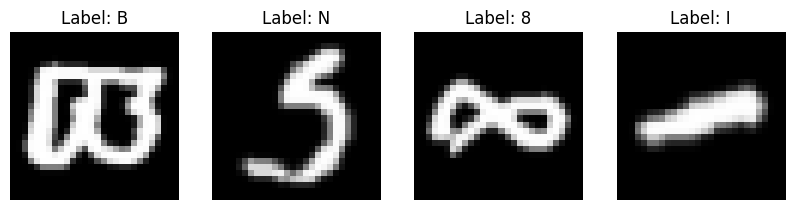

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | conv1 | Sequential | 640    | train
1 | conv2 | Sequential | 640    | train
2 | fc    | Linear     | 254 K  | train
---------------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.021     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Training completed in: 10.79 minutes


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import numpy as np
import time

# Check if CUDA is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Step 1: Download EMNIST dataset
train_dataset = datasets.EMNIST(
    root='/content/sample_data',
    split='byclass',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

test_dataset = datasets.EMNIST(
    root='/content/sample_data',
    split='byclass',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

# Increase batch size to make training faster
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=use_cuda, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=use_cuda, num_workers=4)

# Step 2: Visualize few examples of EMNIST (e.g., 'B' vs. '8', 'S' vs. '5')
def visualize_examples():
    labels = [11, 23, 8, 18]  # Indices for 'B', '8', 'S', '5'
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for i, label in enumerate(labels):
        found = False
        for img, target in train_loader:
            if label in target:
                idx = (target == label).nonzero(as_tuple=True)[0]
                axes[i].imshow(img[idx][0].squeeze(), cmap='gray')
                axes[i].set_title(f"Label: {train_dataset.classes[label]}")
                axes[i].axis('off')
                found = True
                break
        if not found:
            print(f"Label {label} not found in the current batch")
    plt.show()

visualize_examples()

# Step 3: Define Bilinear Pooling Network using PyTorch Lightning
class BilinearCNN(pl.LightningModule):
    def __init__(self, num_classes=62, lr=0.001):
        super(BilinearCNN, self).__init__()
        self.lr = lr

        # Define two convolutional streams
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(64 * 64, num_classes)

        # Track loss and accuracy for plotting
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x):
        # Apply two convolutional streams
        x1 = self.conv1(x)
        x2 = self.conv2(x)

        # Reshape for bilinear pooling
        x1 = x1.view(x1.size(0), 64, -1)  # (batch_size, num_features, feature_dim)
        x2 = x2.view(x2.size(0), 64, -1)

        # Bilinear pooling using torch.bmm()
        bilinear_output = torch.bmm(x1, x2.transpose(1, 2))  # (batch_size, num_features, num_features)
        bilinear_output = bilinear_output.view(bilinear_output.size(0), -1)  # Flatten

        # Fully connected layer
        output = self.fc(bilinear_output)
        return output

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', accuracy, prog_bar=True)
        self.val_losses.append(loss.item())
        self.val_accuracies.append(accuracy)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# Step 4: Train the model using PyTorch Lightning Trainer
model = BilinearCNN(num_classes=62)

start_time = time.time()
trainer = pl.Trainer(max_epochs=3, devices=1 if use_cuda else None, accelerator='gpu' if use_cuda else 'cpu')
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)
end_time = time.time()
print(f"Training completed in: {(end_time - start_time) / 60:.2f} minutes")



